# PT03 - Die MNIST-DB und PyTorch

In [12]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset

%matplotlib inline

### Warnungen ausschalten

In [13]:
import warnings
warnings.filterwarnings("ignore")

### GPU-Check

In [3]:
device =  "cuda" if torch.cuda.is_available else "cpu"

### MNIST-Datensatz einlesen

In [14]:
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

transform = transforms.Compose([transforms.ToTensor(),])

trainset = torchvision.datasets.MNIST(root='./data/', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data/', train=False, download=True, transform=transform)

class MNISTDataset(Dataset):
  def __init__(self, X, y):

    self.X = X.type(torch.cuda.FloatTensor).to(device)
    self.y = nn.functional.one_hot(y).type(torch.cuda.FloatTensor).to(device)
  def __len__(self):
    return len(self.X)


  def __getitem__(self, idx):
    features = self.X[idx]
    target = self.y[idx]
    return features, target


train_dataset = MNISTDataset(trainset.data, trainset.targets)
test_dataset = MNISTDataset(testset.data, testset.targets)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=32)

Feature batch shape: torch.Size([32, 28, 28])
Labels batch shape: torch.Size([32, 10])


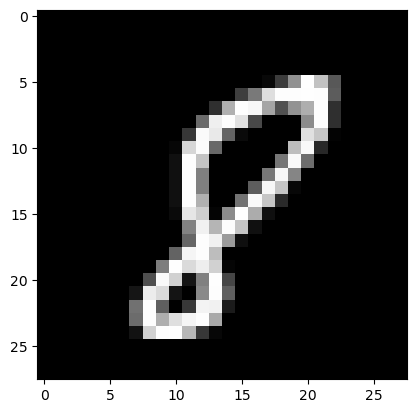

Label: 8


In [15]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze().to("cpu")
label = train_labels[0].to("cpu")
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label.argmax().item()}")


### Die Klasse Classifier

In [16]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layer 1
        self.conv1 = nn.Conv2d(1, 32, 3, 1)

        # Convolutional layer 2
        self.conv2 = nn.Conv2d(32, 64, 3, 1)

        # Fully connected layer 1
        self.fc1 = nn.Linear(1600, 1200)

        # Fully connected layer 2
        self.fc2 = nn.Linear(1200, 10)

    def forward(self, x):
        # Pass the input image through the convolutional layers
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)

        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)

        # Flatten the output from the convolutional layers
        x = x.view(-1, 1600)

        # Pass the output from the convolutional layers through the fully connected layers
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)

        # Return the output of the fully connected layers
        return x

#### Training des Netzes

In [18]:
model = MyModel().to(device)
 

In [22]:
from tqdm import tqdm
import torch.optim as optim
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 5


print("So it begins")
model.train()
for epoch in tqdm(range(n_epochs)):
    for X_batch, y_batch in train_loader:

        X_batch = X_batch.unsqueeze(1)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Finished epoch {epoch}, latest loss {loss}')


So it begins


 20%|██        | 1/5 [00:07<00:29,  7.46s/it]

Finished epoch 0, latest loss 0.14645369350910187


 40%|████      | 2/5 [00:14<00:22,  7.38s/it]

Finished epoch 1, latest loss 0.006371030583977699


 60%|██████    | 3/5 [00:22<00:14,  7.37s/it]

Finished epoch 2, latest loss 0.0031177436467260122


 80%|████████  | 4/5 [00:29<00:07,  7.35s/it]

Finished epoch 3, latest loss 0.19576381146907806


100%|██████████| 5/5 [00:36<00:00,  7.35s/it]

Finished epoch 4, latest loss 0.023618120700120926


#### Test des Netzes

In [23]:
import torchmetrics
# Initialize precision and recall metrics
precision_metric = torchmetrics.Precision(task="multiclass", num_classes=10).to(device)
recall_metric = torchmetrics.Recall(task="multiclass", num_classes=10).to(device)
accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)



# Iterate over the test data
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        # Make predictions
        X_batch = X_batch.unsqueeze(1)
        outputs = model(X_batch)

        # Update accuracy metric

        _, predicted = torch.max(outputs.data, 1)
        _, y_batch = torch.max(outputs.data, 1)

        accuracy_metric.update(predicted, y_batch)
        precision_metric.update(predicted, y_batch)
        recall_metric.update(predicted, y_batch)




# Calculate average precision and recall
accuracy = precision_metric.compute()
precision = precision_metric.compute()
recall = recall_metric.compute()
print('Accuracy on test data: %f' % accuracy)
print('Precision on test data: %f' % precision)
print('Recall on test data: %f' % recall)

Accuracy on test data: 1.000000
Precision on test data: 1.000000
Recall on test data: 1.000000
